In [3]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import geopandas as gpd
import xarray as xr
import rioxarray
import rasterio
import geemap
import matplotlib.pyplot as plt

import ee


In [4]:
ee.Initialize(project='ee-kiwa') 

In [4]:
# era5_path = "data/external/raw/Climate_Data/ERA5_Land_Monthly/faac4feca8ab6311a2c2b0257df06e78/data_0.nc"
era5_path = "C:/Users/cshat/eo/Forest-Fires-Europe/data/raw/Climate_Data/ERA5_Land_Monthly/data_0.nc"
era5 = rioxarray.open_rasterio(era5_path)


In [19]:
era5

<xarray.Dataset> Size: 451MB
Dimensions:      (x: 501, y: 251, valid_time: 299)
Coordinates:
  * x            (x) float64 4kB -10.0 -9.9 -9.8 -9.7 ... 39.7 39.8 39.9 40.0
  * y            (y) float64 2kB 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * valid_time   (valid_time) object 2kB 2000-01-01 00:00:00 ... 2024-11-01 0...
    spatial_ref  int32 4B 0
Data variables:
    t2m          (valid_time, y, x) float32 150MB ...
    d2m          (valid_time, y, x) float32 150MB ...
    evabs        (valid_time, y, x) float32 150MB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
print("Variables in the dataset:", era5.data_vars)


Variables in the dataset: Data variables:
    t2m      (valid_time, y, x) float32 150MB ...
    d2m      (valid_time, y, x) float32 150MB ...
    evabs    (valid_time, y, x) float32 150MB ...


In [8]:
# Select the first variable (replace with a specific variable name if needed)
variable_name = list(era5.data_vars.keys())[0]  # Get the first variable
selected_variable = era5[variable_name]

# Inspect the dimensions and coordinates
print("Dimensions:", selected_variable.dims)
print("Coordinates:", selected_variable.coords)

Dimensions: ('valid_time', 'y', 'x')
Coordinates: Coordinates:
  * x            (x) float64 4kB -10.0 -9.9 -9.8 -9.7 ... 39.7 39.8 39.9 40.0
  * y            (y) float64 2kB 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * valid_time   (valid_time) object 2kB 2000-01-01 00:00:00 ... 2024-11-01 0...
    spatial_ref  int32 4B 0


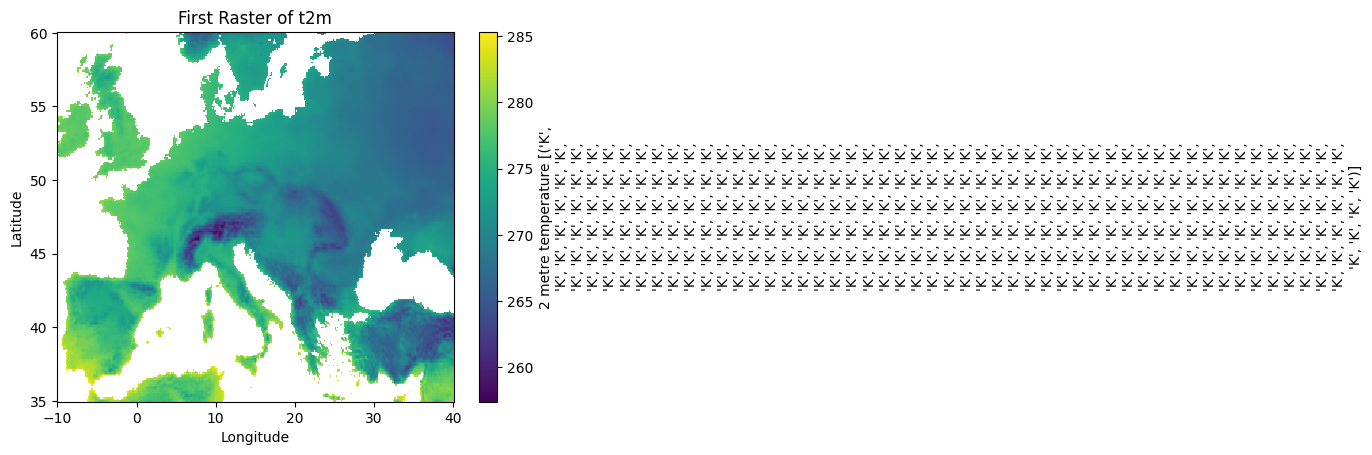

In [11]:

# Plot the first raster
if "time" in selected_variable.dims:  # Replace 'time' with 'valid_time' if that is your time dimension
    selected_variable.isel(time=0).plot(cmap="viridis")  # First time step
elif "valid_time" in selected_variable.dims:
    selected_variable.isel(valid_time=0).plot(cmap="viridis")  # For valid_time dimension
else:
    selected_variable.plot(cmap="viridis")  # If no time dimension exists

# Add title and labels
plt.title(f"First Raster of {variable_name}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()